# Get data - example

In [1]:
from datetime import datetime, timedelta

#import xarray as xr

import pystac_client
#import stackstac

from dask.diagnostics import ProgressBar

dx = 3/3600  # 90m resolution
epsg = 4326
# random location in the middle of the Amazon
bounds = (-64.0, -9.0, -63.5, -8.5)
minx, miny, maxx, maxy = bounds
geom = {
    'type': 'Polygon',
    'coordinates': [[
       [minx, miny],
       [minx, maxy],
       [maxx, maxy],
       [maxx, miny],
       [minx, miny]
    ]]
}


year = 2020
month = 1

start_date = datetime(year, month, 1)
end_date = start_date + timedelta(days=31)
date_query = start_date.strftime("%Y-%m-%d") + "/" + end_date.strftime("%Y-%m-%d")


items = pystac_client.Client.open(
    "https://earth-search.aws.element84.com/v1"
).search(
    intersects=geom,
    collections=["sentinel-2-l2a"],
    datetime=date_query,
    limit=100,
).item_collection()

print(len(items), "scenes found")

52 scenes found


In [ ]:
for item in items:
    print(item.id)

# odc-cube - example

In [2]:
import odc.stac
from odc.geo.geobox import GeoBox

# define a geobox for my region
geobox = GeoBox.from_bbox(bounds, crs=f"epsg:{epsg}", resolution=dx)

# lazily combine items
ds_odc = odc.stac.load(
    items,
    bands=["scl", "red", "green", "blue"],
    chunks={'time': 5, 'x': 600, 'y': 600},
    geobox=geobox,
    resampling="bilinear"
)

In [3]:
# actually load it
with ProgressBar():
    ds_odc.load()

[                                        ] | 0% Completed | 10.39 sus

/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


[########################################] | 100% Completed | 108.78 s


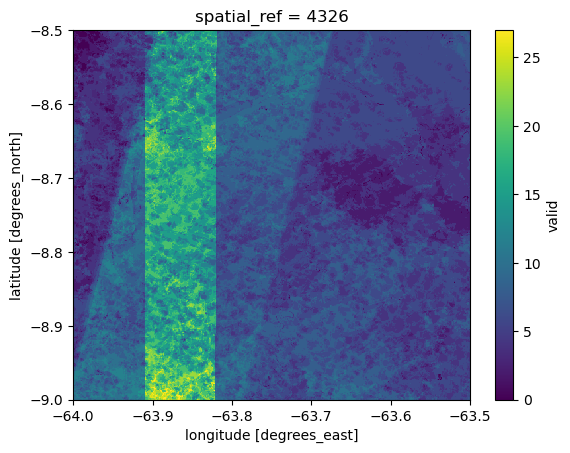

In [4]:
from rasterio.enums import Resampling
# define a mask for valid pixels (non-cloud)

def is_valid_pixel(data):
    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

ds_odc['valid'] = is_valid_pixel(ds_odc.scl)
ds_odc.valid.sum("time").plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


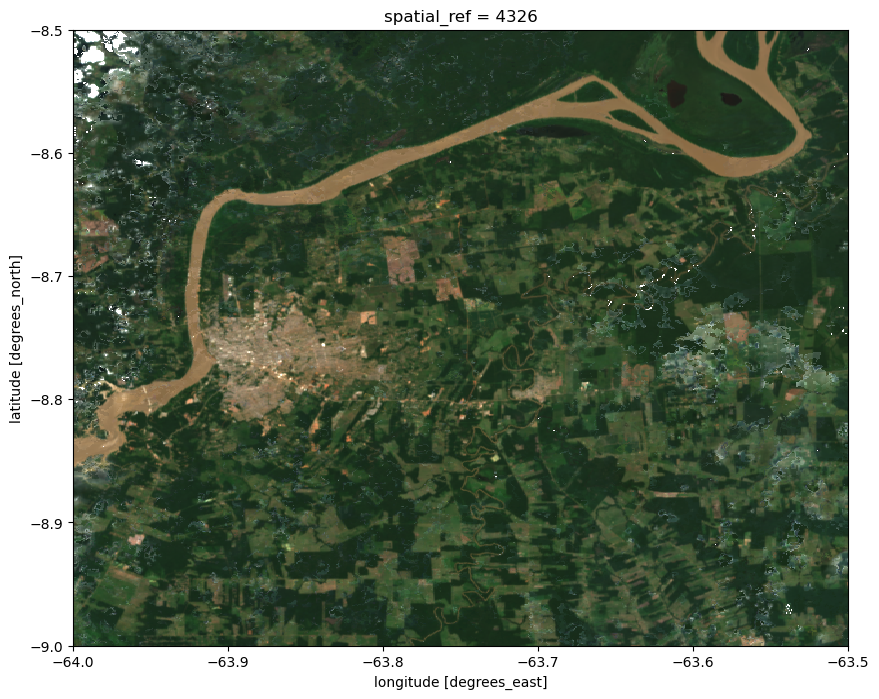

In [5]:
# compute the masked median
rgb_median = (
    ds_odc[['red', 'green', 'blue']]
    .where(ds_odc.valid)
    .to_dataarray(dim="band")
    .transpose(..., "band")
    .median(dim="time")
)
(rgb_median / rgb_median.max() * 2).plot.imshow(rgb="band", figsize=(10, 8))

In [6]:
print(ds_odc.longitude.values[:5])

[-63.99958333 -63.99875    -63.99791667 -63.99708333 -63.99625   ]


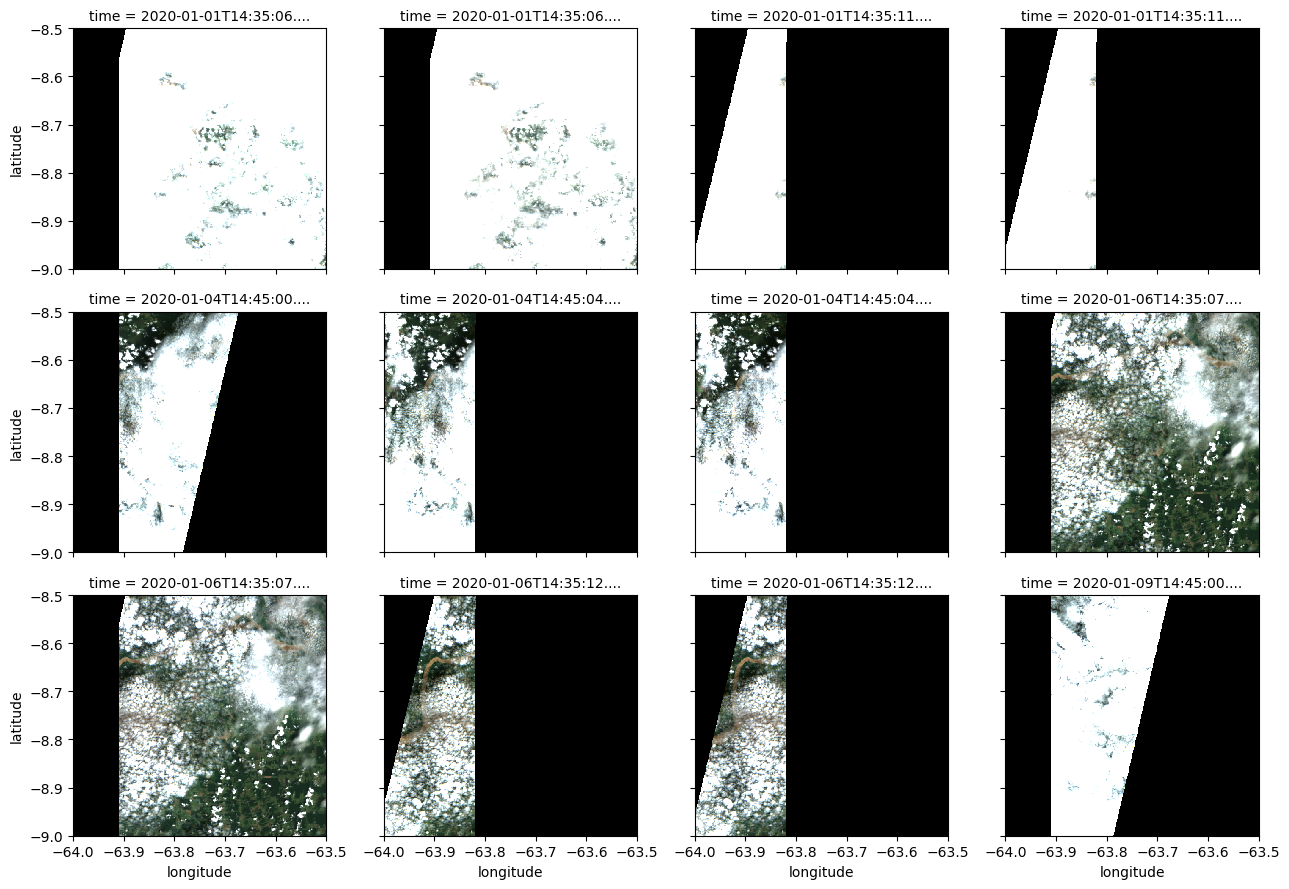

In [16]:

# Show the raw data
ds_odc[["red", "green", "blue"]].isel(time=slice(0, 12)).to_array().plot.imshow(
    col="time", col_wrap=4, vmin=0, vmax=3000
)

# Get data - EODH

In [6]:
import pyeodh

client = pyeodh.Client().get_catalog_service()

# GET /stac-fastapi/catalogs
#service = client.get_catalog_service()
#catalogs = service.get_catalogs()
#ceda_cat = service.get_catalog("supported-datasets/ceda-stac-fastapi")

for coll in client.get_collections():
    print(f"{coll.id}: {coll.description}")

cmip6: CMIP6
cordex: CORDEX
ukcp: UKCP
0fcb2296-2411-11ef-bcbd-da6b61b15d6d: description
93cdafea-1dc8-11ef-968f-6a7abc48984c: description
97d80a3c-1dc7-11ef-92a3-6a7abc48984c: description
ad608ce4-1d0e-11ef-8036-563e2ce721d4: description
1440d164-1376-11ef-b8ab-e20b664dd0f8: description
093927f4-12ad-11ef-94e9-7e375e8a9c97: description
sentinel2_ard: sentinel 2 ARD


In [8]:
sentinel2_ard = client.get_catalog("supported-datasets/ceda-stac-fastapi").get_collection('sentinel2_ard')
print(sentinel2_ard.extent.spatial.bboxes)
print([str(d) for d in sentinel2_ard.extent.temporal.intervals[0]])


[[-9.00034454651177, 49.48562028352171, 3.1494256015866995, 61.33444247301668]]
['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']


In [17]:
#item_search = client.search(
#    collections=['sentinel2_ard'],
#    datetime="2023-01-01/2023-02-28",
#    catalog_path=["supported-datasets/ceda-stac-fastapi"],
#    limit=10,
#)

items = client.search(
    collections=["sentinel2_ard"],
    catalog_paths=["supported-datasets/ceda-stac-fastapi"],
    datetime="2023-01-01/2023-02-28",
    limit=100,
)
print(items.total_count)

for item in items:
    print(item.properties["start_datetime"], item.properties["end_datetime"])

TypeError: Catalog.search() got an unexpected keyword argument 'catalog_paths'